# BTC Prediction (Modeling Stage)

### This notebook contains:

The prediction of BTCs next day close price using various models and methods. The X variable is the features used to predict the price, and the y variable is our target prediction. The target prediction is simply the next days close price shifted to fit each row. 

#### Models Used:

- Linear regression (LR)
    - Ordinary Least Squares (OLS)
    - Lasso
    - Ridge
- Random forest regression (RFR)
- Time series forecasting with long short term memory (LSTM)

Both linear and random forest regression utilize _GridSearchCV()_ to tune hyperparameters. Using grid search through the model pipeline I added an additional tuner as _PolynomialFeatures()_. Polynomial features usually improves linear regression models significantly. For the regression specific portion of testing I compute the R2, MAE, MSE, MAPE, RMSE score for each model and additionally the OOB (Out of Bag) score for the RFR. 

As for the time series forecasting using LSTM, I utilize a "Keras" wrapper called "Hyperas" in order to tune the LSTM hyperparameters (i.e. Dropout, Activation, Dense, Optimizer, Batch Size and Epochs). Hyperas is a more streamlined version of "Hyperopt", providing a more versatile way to alter parameters and tune layers. The loss metric used is MSE in conjunction with the MAE. Since the overall goal of the project is a regression "problem", accuracy is not applicable. Accuracy as a measure only applies for classification (discrete outputs), comparing for equality. With regression we are predicting a continuous value (price), so if the target is 0.99 and the network predicts 1.0, then it would be considered as misclassified. 

That being said, after running the models you will see graphical representations as subplots(scatter and line plot) demonstrating their performance for each. The visuals show the actual close price compared to the predicted price from each model. The LSTM also includes a plot of the training loss compared to the validation loss.

In [14]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics

import statsmodels.api as sm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [15]:
dataset = pd.read_csv('data/train.csv', index_col='Date')

In [16]:
dataset.head()

,close,volume,ema_short,ema_long,atr,obv,tweet_sentiment,close_nextday
Date,,,,,,,,
2019-09-02,10340.00,44740.25,10164.518939,10452.265343,530.693553,225053.863244,-1.0,10615.28
2019-09-03,10615.28,47998.38,10207.448563,10458.658074,528.572585,273052.240025,0.5,10567.02
2019-09-04,10567.02,43943.89,10241.693462,10462.907561,521.468114,229108.350999,0.5,10564.49
2019-09-05,10564.49,33970.96,10272.435990,10466.891187,516.363249,195137.390360,0.5,10298.73
2019-09-06,10298.73,58799.64,10274.940181,10460.296630,533.470874,136337.749401,0.0,10455.88


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 2019-09-02 to 2020-11-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   close            441 non-null    float64
 1   volume           441 non-null    float64
 2   ema_short        441 non-null    float64
 3   ema_long         441 non-null    float64
 4   atr              441 non-null    float64
 5   obv              441 non-null    float64
 6   tweet_sentiment  441 non-null    float64
 7   close_nextday    441 non-null    float64
dtypes: float64(8)
memory usage: 31.0+ KB


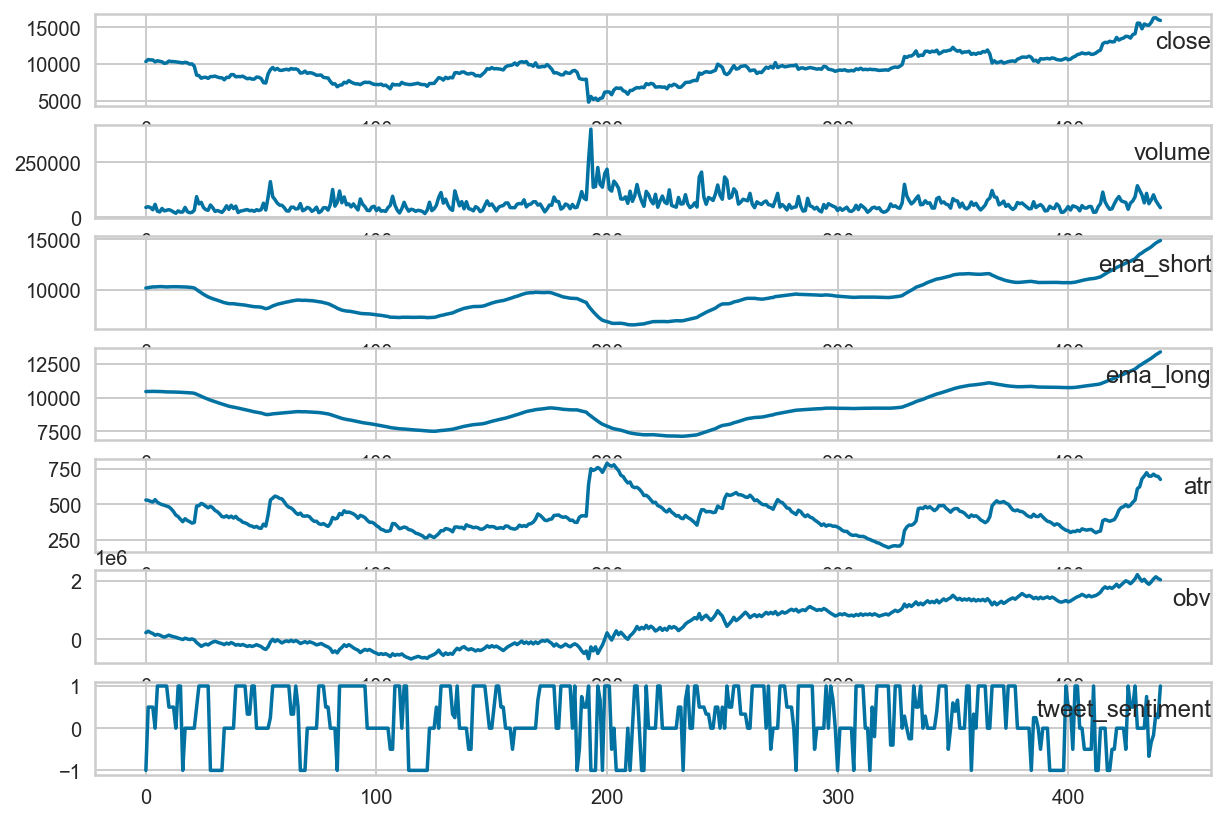

In [18]:
import matplotlib.pyplot as plt

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(10, 7))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# Modeling

We split the original dataset using _TimeSeriesSplit()_, making our X every feature except "close_nextday". The target is "close_nextday" so we use that variable as our y. The split used was a 75% train and 25% test. X_train and y_train are the first 75% of the original dataset and X_test, y_test contain the last 25% of the original dataset.

### Techniques:

##### - Ordinary Least Squares (OLS)
    
Minimizes bias of OLS function with the "Best Linear Unbiased Estimator" (BLUE).
    
\begin{equation}
\mathcal{L}_{OLS} = ||Y-X^T\beta||^2
\end{equation}
    
##### - Lasso

Different minimization function than OLS. Penalizes large beta values.
    
\begin{equation}
\mathcal{L}_{LASSO}  = ||Y - X^T\beta||^2 + \lambda ||\beta||
\end{equation}

##### - Ridge

Has a similar penalty of beta values as Lasso, but has a different "bias".
    
\begin{equation}
\mathcal{L}_{Ridge} = ||Y - X^T\beta||^2 + \lambda ||\beta||^2
\end{equation}
<br>
<br>

**Both Lasso and Ridge Regressions are considered to have _good_ bias as long as:**

\begin{equation}
\lambda > 0
\end{equation}

**They are considered to be "better" in performance compared to OLS because of this _good_ bias, although, that is not always the case.** 
<br>
##### - Random Forest Regressor (RFR)

A supervised learning ensemble method that uses a bagging technique where its trees run parallel and do not interact. As a "meta-estimator" it combines multiple predictions (trees), and produces outputs from the best performance of those aggregate estimations.

### Tuning Hyperparameters:

##### - Pipeline
- PolynomialFeatures()
- OLS, Lasso, Ridge



##### - GridSearchCV Params:
- Lasso, Ridge: "fit_alpha"
- RFR: "n_estimators", "max_depth", "max_features", "bootstrap"

## Train/Test

In [19]:
# Subset dataset into X, y. X is features, y is target

X = dataset.drop(labels=['close_nextday'], axis=1)
y = dataset['close_nextday']

print(y.head())

Date
2019-09-02    10615.28
2019-09-03    10567.02
2019-09-04    10564.49
2019-09-05    10298.73
2019-09-06    10455.88
Name: close_nextday, dtype: float64


In [20]:
# Split X, y using TimeSeriesSplit() into X_train, X_test, y_train, y_test. First 75% is training, 25% is test

tss = TimeSeriesSplit(n_splits=3)  # n_splits = 3-1...2 splits

for train_index, test_index in tss.split(X):
    X_train_split, X_test_split = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]

In [21]:
# Check train, test splits for correct date alignment and matching shape

print("X_train:\n", X_train_split, X_train_split.shape, "\n", '\nX_test:\n', X_test_split,
      X_test_split.shape)
print("\n")
print("y_train:\n", y_train_split, y_train_split.shape, "\n", '\ny_test:\n', y_test_split,
      y_test_split.shape)

X_train:
                close     volume     ema_short      ema_long         atr  \
Date                                                                      
2019-09-02  10340.00   44740.25  10164.518939  10452.265343  530.693553   
2019-09-03  10615.28   47998.38  10207.448563  10458.658074  528.572585   
2019-09-04  10567.02   43943.89  10241.693462  10462.907561  521.468114   
2019-09-05  10564.49   33970.96  10272.435990  10466.891187  516.363249   
2019-09-06  10298.73   58799.64  10274.940181  10460.296630  533.470874   
...              ...        ...           ...           ...         ...   
2020-07-24   9537.80   43931.14   9319.820787   9252.782403  206.397467   
2020-07-25   9700.42   40679.55   9356.068331   9270.336819  207.361933   
2020-07-26   9931.54   65279.27   9410.875156   9296.266355  225.478938   
2020-07-27  11029.96  150188.93   9565.073713   9364.254341  314.919728   
2020-07-28  10906.27   97267.73   9692.806693   9424.725543  340.799033   

              

In [22]:
# Reshape y train, test to match X train, test

y_train = y_train_split.values.reshape(-1, 1)
y_test = y_test_split.values.reshape(-1, 1)

print(y_test)

[[11099.61]
 [11335.46]
 [11801.17]
 [11071.35]
 [11219.81]
 [11191.97]
 [11744.91]
 [11762.46]
 [11594.23]
 [11761.41]
 [11681.68]
 [11892.92]
 [11392.08]
 [11564.33]
 [11780.  ]
 [11760.54]
 [11852.4 ]
 [11911.  ]
 [12281.13]
 [11945.01]
 [11754.59]
 [11853.55]
 [11531.34]
 [11662.96]
 [11648.13]
 [11748.2 ]
 [11318.42]
 [11461.43]
 [11330.38]
 [11526.91]
 [11465.84]
 [11711.16]
 [11649.51]
 [11921.97]
 [11388.54]
 [10140.85]
 [10446.25]
 [10166.69]
 [10256.2 ]
 [10373.44]
 [10126.65]
 [10219.2 ]
 [10336.87]
 [10387.89]
 [10440.92]
 [10332.83]
 [10671.77]
 [10785.31]
 [10954.01]
 [10939.99]
 [10933.39]
 [11080.65]
 [10920.28]
 [10417.22]
 [10529.61]
 [10241.46]
 [10736.32]
 [10686.67]
 [10728.6 ]
 [10774.25]
 [10696.12]
 [10840.48]
 [10776.59]
 [10619.13]
 [10570.4 ]
 [10542.06]
 [10666.63]
 [10792.21]
 [10599.66]
 [10666.39]
 [10925.57]
 [11050.64]
 [11293.22]
 [11369.02]
 [11528.25]
 [11420.56]
 [11417.89]
 [11505.12]
 [11319.32]
 [11360.2 ]
 [11503.14]
 [11751.47]
 [11909.99]
 [12

In [23]:
# Scale X_train, X_test, y_train, y_test to prevent overfitting and minimize outliers like large values

ss = StandardScaler()

X_train = ss.fit_transform(X_train_split)
X_test = ss.fit_transform(X_test_split)
y_train = ss.fit_transform(y_train)
y_test = ss.fit_transform(y_test)

In [24]:
# Make sure shape is same before scaling. 

print("X Train:", type(X_train), X_train.shape, len(X_train))
print("\nX Test:", type(X_test), X_test.shape, len(X_test))
print("\ny Train:", type(y_train), y_train.shape, len(y_train))
print("\ny Test:", type(y_test), y_test.shape, len(y_test))

X Train: <class 'numpy.ndarray'> (331, 7) 331

X Test: <class 'numpy.ndarray'> (110, 7) 110

y Train: <class 'numpy.ndarray'> (331, 1) 331

y Test: <class 'numpy.ndarray'> (110, 1) 110


In [27]:
# Test function to run prediction error metrics from model pipline 

def test(models, iterations=100):
    results = {}
    for i in models:
        r2_test = []
        r2_train = []
        MAE_test = []
        MAE_train = []
        MSE_test = []
        MSE_train = []
       
        for j in range(iterations):
            r2_test.append(
                metrics.r2_score(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            r2_train.append(
                metrics.r2_score(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MAE_test.append(
                metrics.mean_absolute_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MAE_train.append(
                metrics.mean_absolute_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MSE_test.append(
                metrics.mean_squared_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MSE_train.append(
                metrics.mean_squared_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
          

        results[i] = [
            np.mean(r2_train),
            np.mean(r2_test),
            np.mean(MAE_train),
            np.mean(MAE_test),
            np.mean(MSE_train),
            np.mean(MSE_test)
        ]

    return pd.DataFrame(results)

In [28]:
# Build GridSearchCV params for models with pipeline

lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}
rfr_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth': range(20, 30),
    #'min_samples_split': range(1, 10),
    #'min_samples_leaf': range(1, 5),
    "max_features": ["auto"],
    "bootstrap": [True, False]
}

pipe1 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.LinearRegression())])
pipe2 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Lasso())])
pipe3 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Ridge())])

models = {
    'OLS':
    pipe1,
    'Lasso':
    GridSearchCV(pipe2, param_grid=lasso_params).fit(
        X_train, y_train).best_estimator_,
    'Ridge':
    GridSearchCV(pipe3, param_grid=ridge_params).fit(
        X_train, y_train).best_estimator_,
    'RFR':
    GridSearchCV(RandomForestRegressor(oob_score=True), param_grid=rfr_params).fit(
        X_train, y_train).best_estimator_,
}

In [29]:
models.keys()

dict_keys(['OLS', 'Lasso', 'Ridge', 'RFR'])

In [30]:
# Create model test variables for visual performance evaluation

pred_ols = models['OLS'].fit(X_train, y_train).predict(X_test)
pred_lasso = models['Lasso'].fit(X_train, y_train).predict(X_test)
pred_ridge = models['Ridge'].fit(X_train, y_train).predict(X_test)
pred_rfr = models['RFR'].fit(X_train, y_train).predict(X_test)

In [31]:
# Model performance comparision between train and test

scores = test(models)
scores = scores.T
scores.columns = [
    'R^2 Test', 'R^2 Train', 'MAE Test', 'MAE Train', 'MSE Test', 'MSE Train'
]
scores['RMSE Train'] = scores['MSE Train']**2
scores['RMSE Test'] = scores['MSE Test']**2
scores['OOB Train'] = models['RFR'].oob_score_
scores.iloc[0,8] = "NA"
scores.iloc[1,8] = "NA"
scores.iloc[2,8] = "NA"

scores.head()

,R^2 Test,R^2 Train,MAE Test,MAE Train,MSE Test,MSE Train,RMSE Train,RMSE Test,OOB Train
OLS,0.938214,0.942125,0.159420,0.170665,0.061786,0.057875,0.003349,0.003817,NA
Lasso,0.930383,0.959676,0.164646,0.133347,0.069617,0.040324,0.001626,0.004847,NA
Ridge,0.753846,0.716989,0.400992,0.419430,0.246154,0.283011,0.080095,0.060592,NA
RFR,0.988445,0.917585,0.067970,0.202374,0.011522,0.081723,0.006679,0.000133,0.91273


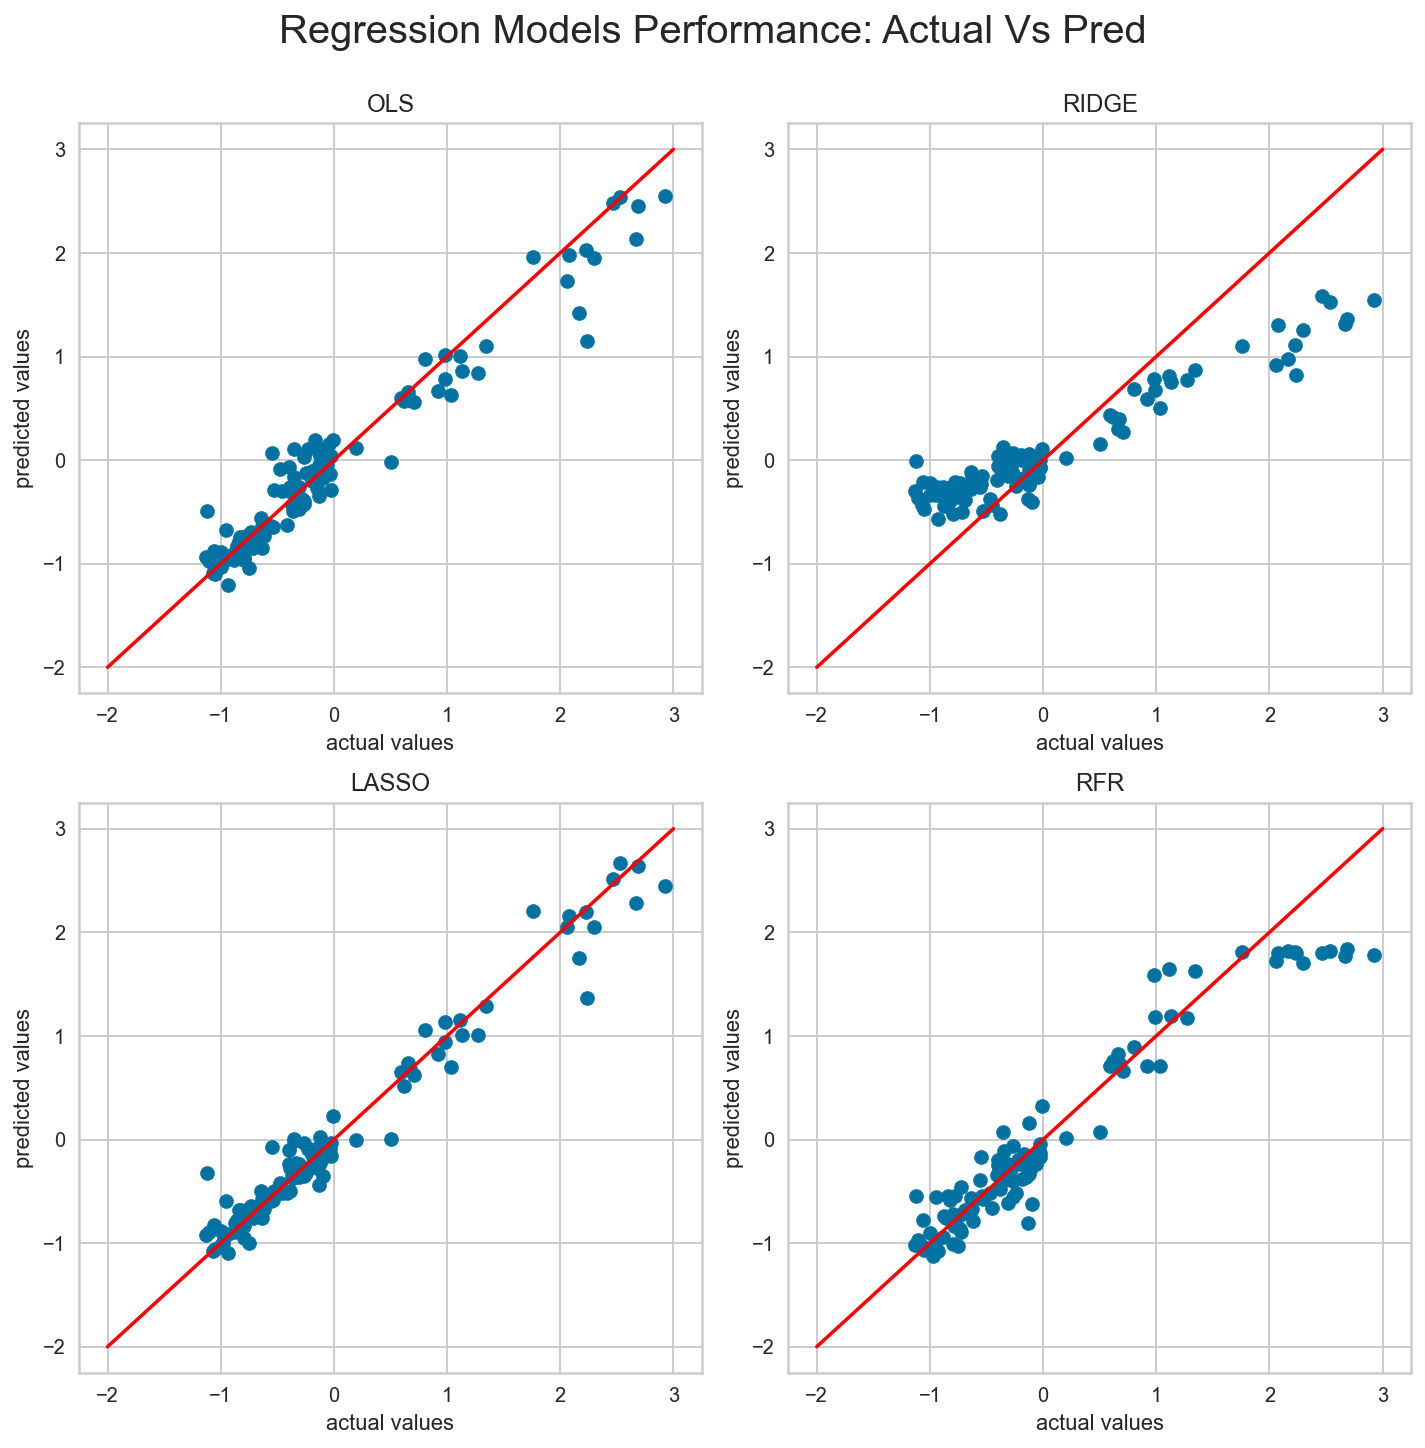

In [32]:
# Performance visual for each model, prediction vs actual subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Regression Models Performance: Actual Vs Pred', fontsize=20, y=1)

axs[0, 0].scatter(y_test, pred_ols)
axs[0, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 0].set_xlabel('actual values')
axs[0, 0].set_ylabel('predicted values')
axs[0, 0].set_title("OLS")

axs[1, 0].scatter(y_test, pred_lasso)
axs[1, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 0].set_xlabel('actual values')
axs[1, 0].set_ylabel('predicted values')
axs[1, 0].set_title("LASSO")

axs[0, 1].scatter(y_test, pred_ridge)
axs[0, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 1].set_xlabel('actual values')
axs[0, 1].set_ylabel('predicted values')
axs[0, 1].set_title("RIDGE")

axs[1, 1].scatter(y_test, pred_rfr)
axs[1, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 1].set_title("RFR")
axs[1, 1].set_xlabel('actual values')
axs[1, 1].set_ylabel('predicted values')
fig.tight_layout()


plt.show()

fig.savefig('RegModels_ActualVsPred_subplot1.png', transparent=False)

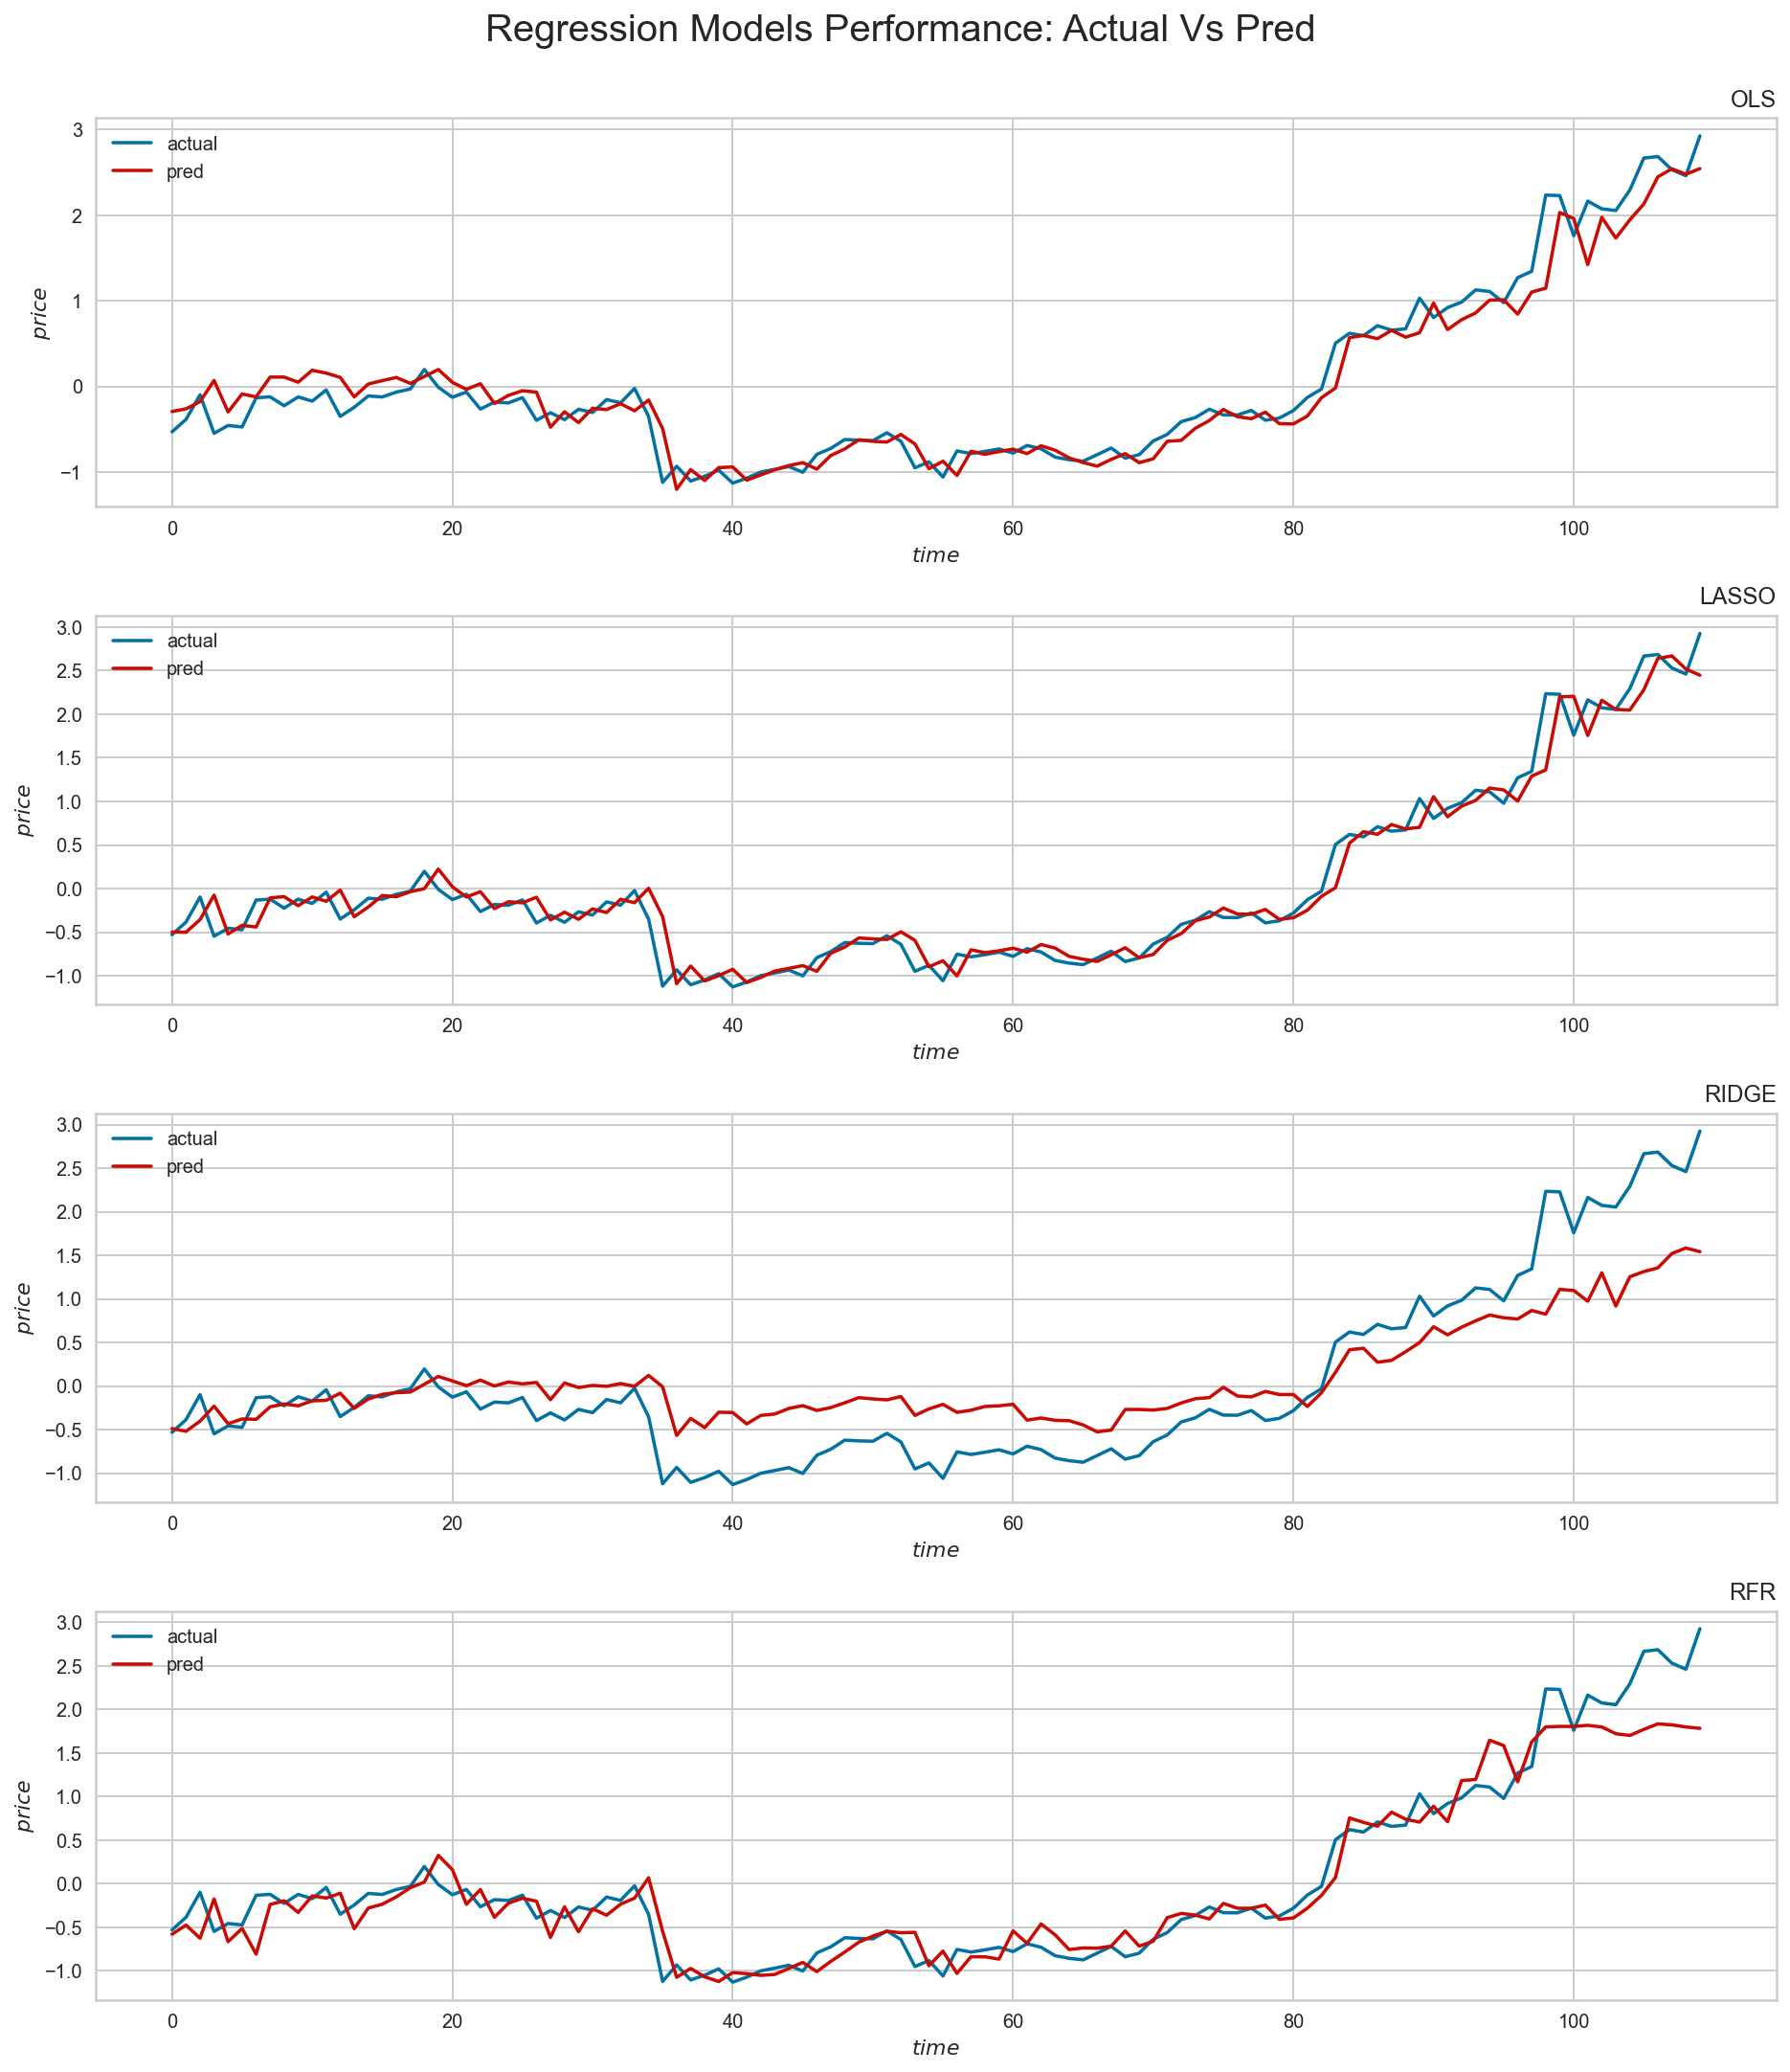

In [33]:
# Performance visual for each model, prediction vs actual subplots

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(13, 15))
fig.suptitle('Regression Models Performance: Actual Vs Pred', fontsize=20, y=1)

ax1.plot(y_test, 'b')
ax1.plot(pred_ols, 'r')
ax1.set_ylabel('$price$')
ax1.set_xlabel('$time$')
ax1.legend(["actual", "pred"])
ax1.set_title("OLS", loc='right')

ax2.plot(y_test, 'b')
ax2.plot(pred_lasso, 'r')
ax2.set_ylabel('$price$')
ax2.set_xlabel('$time$')
ax2.legend(["actual", "pred"])
ax2.set_title("LASSO", loc='right')

ax3.plot(y_test, 'b')
ax3.plot(pred_ridge, 'r')
ax3.set_ylabel('$price$')
ax3.set_xlabel('$time$')
ax3.legend(["actual", "pred"])
ax3.set_title("RIDGE", loc='right')

ax4.plot(y_test, 'b')
ax4.plot(pred_rfr, 'r')
ax4.set_ylabel('$price$')
ax4.set_xlabel('$time$')
ax4.legend(["actual", "pred"])
ax4.set_title("RFR", loc='right')

fig.tight_layout()
plt.show()

fig.savefig('RegModels_ActualVsPred_subplot2.png', transparent=False)

## Feature Importance

In [ ]:
from yellowbrick.model_selection import FeatureImportances

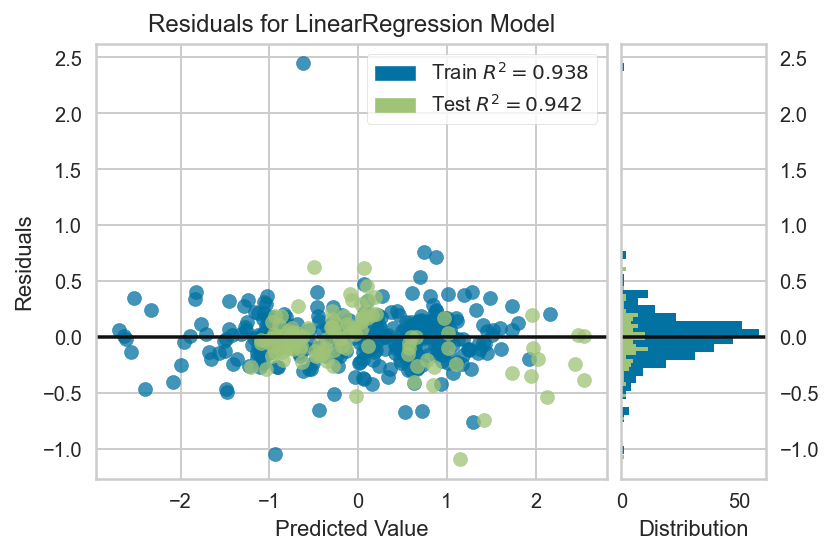

In [77]:
from yellowbrick.regressor import ResidualsPlot

model = models['OLS']
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)   
g = visualizer.show()   

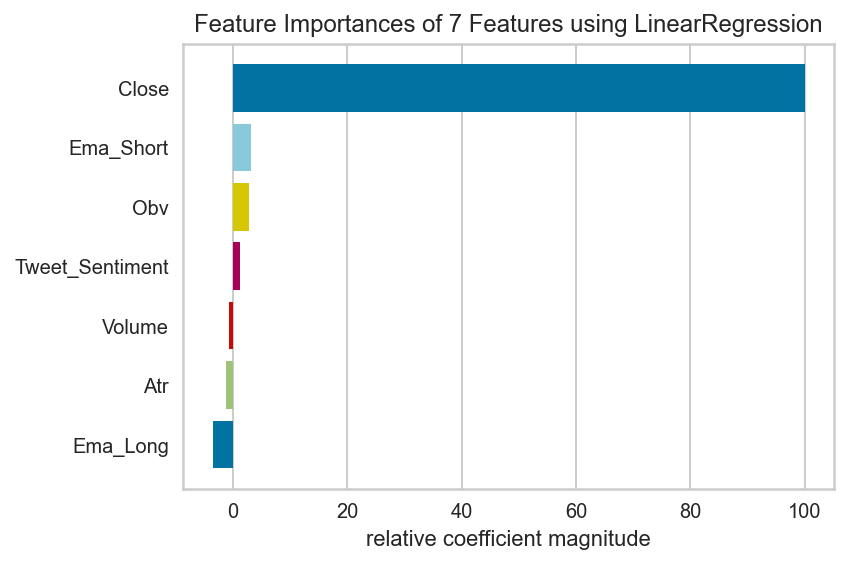

<AxesSubplot:title={'center':'Feature Importances of 7 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [111]:
model =  LinearRegression(models['OLS'])
labels = list(map(lambda s: s.title(), X[['close', 'volume', 'ema_short', 'ema_long', 'atr', 'obv', 'tweet_sentiment']]))
viz = FeatureImportances(model, labels=labels)
viz.fit(X_train, y_train)
viz.show()

## Long Short Term Memory (LSTM)

To run the model, I use the "Hyperas" wrapper of "Keras" based on "Hyperopt". 

- **Process:**
    - Normalization using _MinMaxScaler()_
    - Add "predictor", time steps of "9" from original Y target, "close_nexday"
    - Train, test split - 80% train (352 values) and 20% split (80 values)
    - Create LSTM model
    - Optimize through "Hyperas" 
    - Return output of best performing model from given parameters
<br>   
- **Sequential model layers:**
    - LSTM (choice: 10, 20, 50, 100, 250)
    - Activation (choice: relu, sigmoid, linear, softmax)
    - Dropout (choice: range of 0 to 1)
    - Dense (choice: 1)
<br>
- **Fitting params:**
    - Epochs (choice: 100, 200, 300, 400, 500)
    - Batch size (choice: 2, 4, 5, 8, 10, 16, 20, 40, 80)
    - Validation (X_test, y_test)
    - Callbacks (monitors "val_loss")
    - Suffle = False
<br>
- **Loss metrics:**
    - MSE (mean squared error) 
    - MAE (mean absolute error)
<br>
- **Optimizer:**
    - Choice (rmsprop, adam, sgd, nadam)
    
Through "Hyperas" the functions will run through all the possible layers and choices available to select the best possible combination of those parameters and output the best performing model. Because the loss used is MSE/MAE and not an accuracy metric, hyperas will optimize the models to lower the MSE for each epoch over time. Using the history recorded from model fitting we are able to visualize the optimization process by plotting the training loss against the validation loss. 

You will also find a line plot at the bottom that shows the performance of the best models price predictions against the actual testing values ("close").


>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.model_selection import TimeSeriesSplit
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.preprocessing import PolynomialFeatures
except:
    pass

try:
    from sklearn.linear_model import LinearRegression
except:
    pass

try:
    from sklearn.ensemble import RandomForestRegressor
except:
    pass

try:
    from sklearn import linear_model, preprocessing
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    import statsmodels.api as sm
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import num

  48: 
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.53267, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.53267 to 0.39055, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.39055 to 0.32792, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004: val_loss improved from 0.32792 to 0.27238, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00005: val_loss improved fr

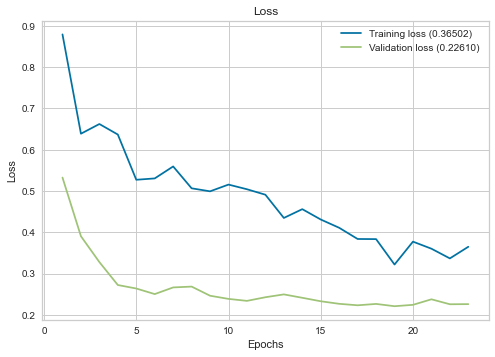

Test loss:                                                                                                             
0.3074621260166168                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07105, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07105 to 0.05180, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05180 to 0.03932, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

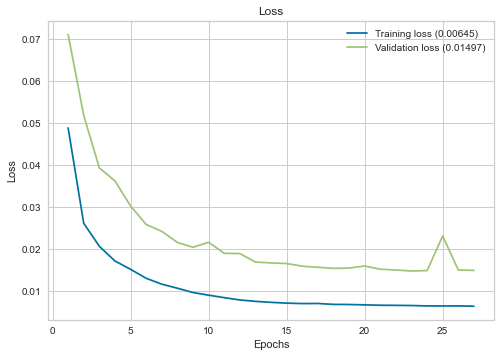

Test loss:                                                                                                             
0.04402325302362442                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.34814, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.34814 to 0.24516, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.24516 to 0.16609, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss did not improve from 0.03014
                                                                                                                       
Epoch 00040: val_loss improved from 0.03014 to 0.03004, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.03004 to 0.03003, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.03003 to 0.02965, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.02965
                         

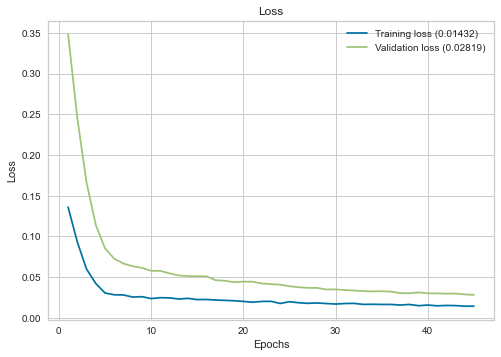

Test loss:                                                                                                             
0.10692618787288666                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.21621, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.21621 to 0.09753, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.09753 to 0.06053, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

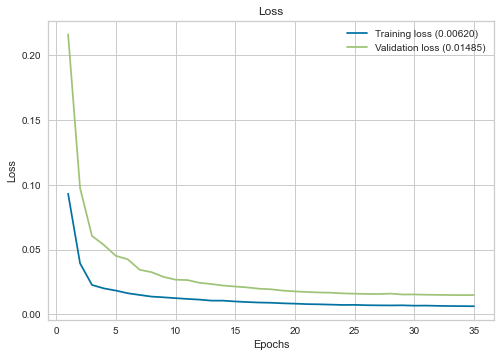

Test loss:                                                                                                             
0.021862652152776718                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38611, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38611 to 0.31329, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.31329 to 0.26320, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00040: val_loss did not improve from 0.10857
                                                                                                                       
Epoch 00041: val_loss improved from 0.10857 to 0.10790, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.10790 to 0.10737, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.10737 to 0.10707, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss improved from 0.10707 to 0.10656, saving model to kera

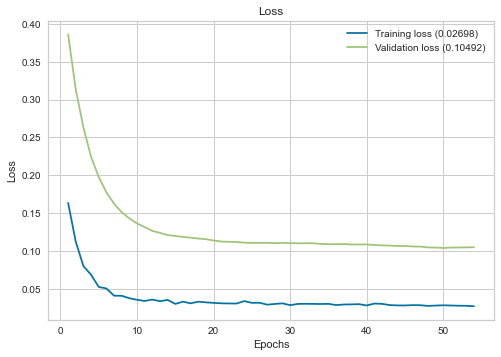

Test loss:                                                                                                             
0.2980579435825348                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.09097, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.09097 to 0.05526, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05526 to 0.03764, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

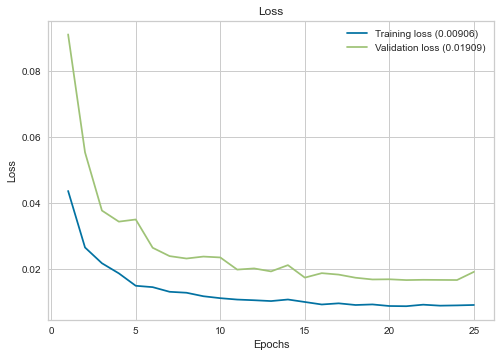

Test loss:                                                                                                             
0.07380174845457077                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.44165, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.44165 to 0.40420, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.40420 to 0.37145, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

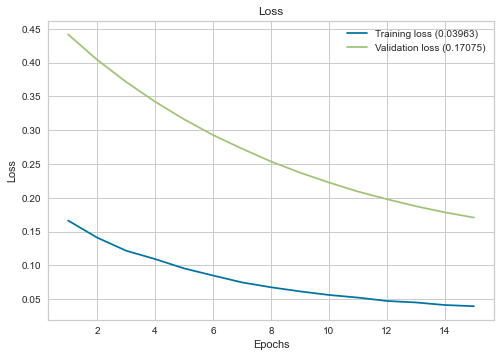

Test loss:                                                                                                             
0.3963591754436493                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.19600, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.19600 to 0.18261, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.18261
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.18261


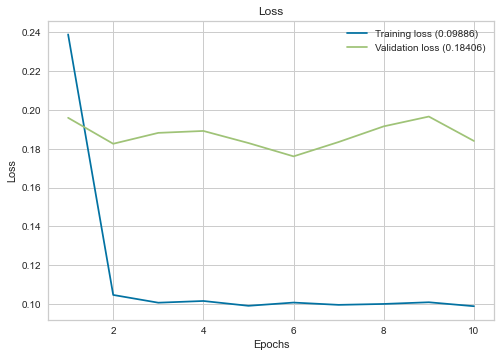

Test loss:                                                                                                             
0.3256066143512726                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.55155, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.55155 to 0.54349, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.54349 to 0.53716, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

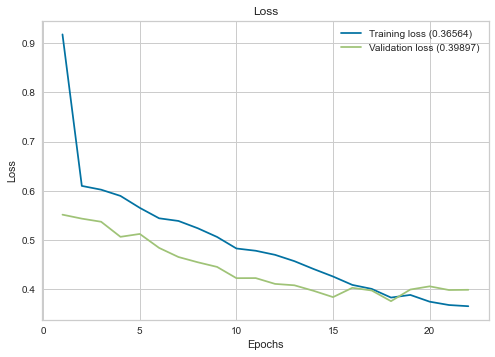

Test loss:                                                                                                             
0.33199411630630493                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.19535, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.19535 to 0.14664, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.14664 to 0.12040, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

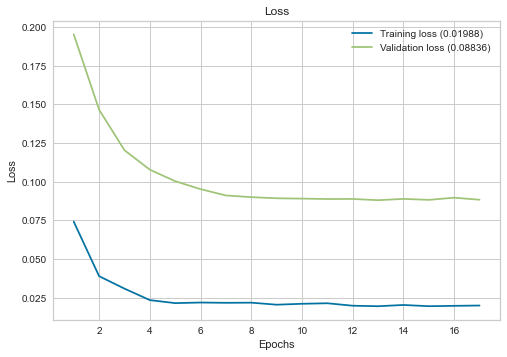

Test loss:                                                                                                             
0.2840389311313629                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.13973, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.13973 to 0.11070, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.11070 to 0.10635, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00041: val_loss did not improve from 0.07420
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.07420
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.07420
 20%|█████████▏                                    | 10/50 [01:37<04:49,  7.23s/trial, best loss: 0.021862652152776718]

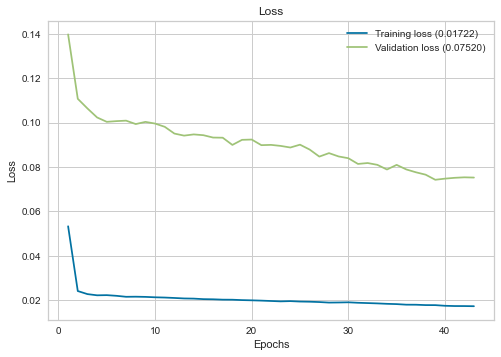

Test loss:                                                                                                             
0.25313955545425415                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.42268, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.42268 to 0.40135, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.40135 to 0.38139, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.13110 to 0.12946, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.12946 to 0.12794, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.12794 to 0.12653, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.12653 to 0.12525, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.12525 to 0.12394, saving model to keras_weights.hdf5
                                                                 

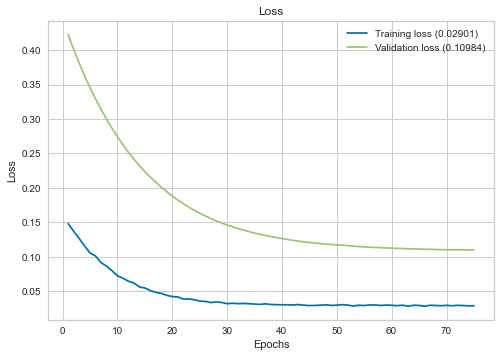

Test loss:                                                                                                             
0.30769872665405273                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.60039, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.60039 to 0.46912, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.46912
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.46912


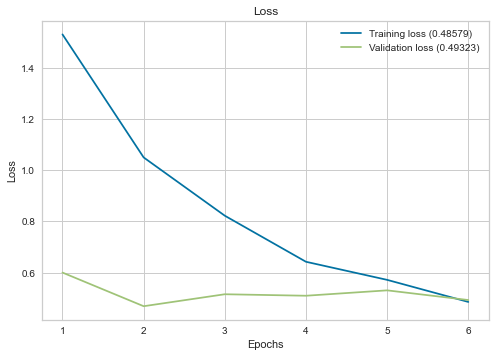

Test loss:                                                                                                             
0.33887436985969543                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38502, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38502 to 0.32065, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.32065 to 0.27326, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

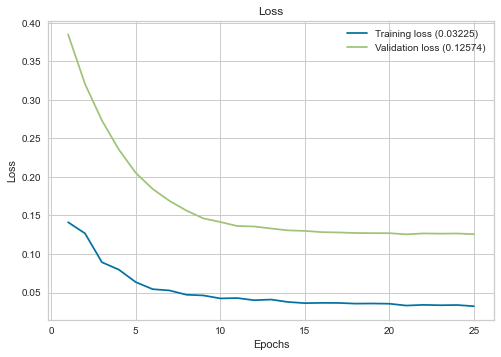

Test loss:                                                                                                             
0.33340269327163696                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38359, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38359 to 0.33464, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.33464 to 0.29286, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

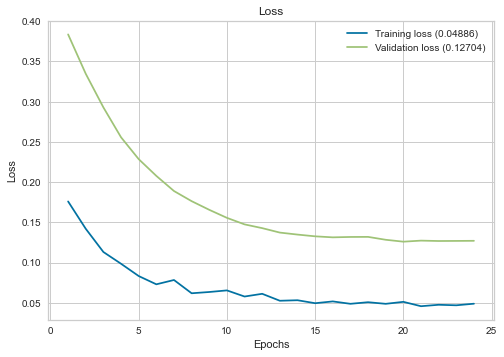

Test loss:                                                                                                             
0.335102379322052                                                                                                      
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.26532, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.26532 to 0.21686, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.21686 to 0.17915, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.06008 to 0.05942, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.05942 to 0.05879, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.05879 to 0.05807, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.05807 to 0.05738, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.05738 to 0.05715, saving model to keras_weights.hdf5
                                                                 

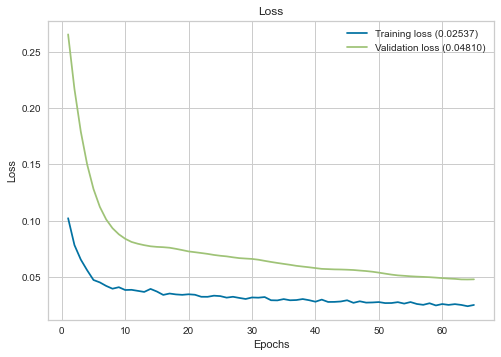

Test loss:                                                                                                             
0.14101861417293549                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.39723, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.39723 to 0.35516, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.35516
                                                                                                                       
Epoch 00004: val_loss improved from 0.35516 to 0.32

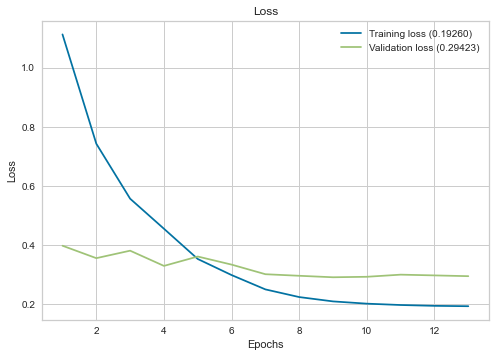

Test loss:                                                                                                             
0.3492709696292877                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38728, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38728 to 0.33607, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.33607 to 0.28985, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.05147 to 0.05003, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.05003 to 0.04780, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.04780 to 0.04665, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.04665 to 0.04591, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.04591
                                                                                                         

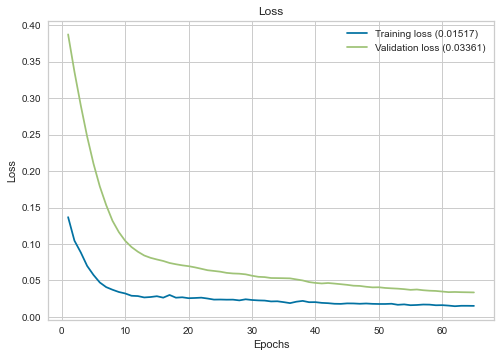

Test loss:                                                                                                             
0.12261217832565308                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.26249, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.26249 to 0.20255, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.20255 to 0.16610, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00040: val_loss improved from 0.09474 to 0.09449, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.09449 to 0.09331, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.09331 to 0.09135, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.09135 to 0.09065, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss did not improv

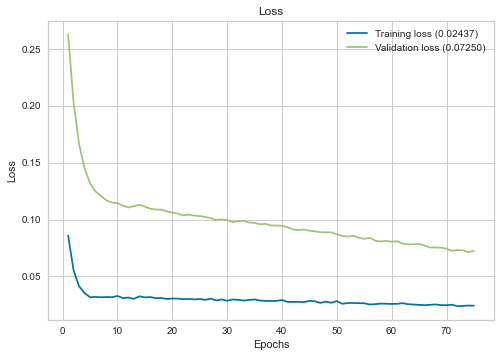

Test loss:                                                                                                             
0.23567014932632446                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.43159, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.43159 to 0.40017, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.40017 to 0.36937, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

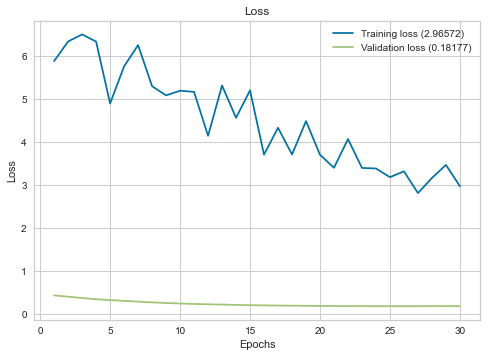

Test loss:                                                                                                             
0.17600639164447784                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.09286, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.09286 to 0.07084, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.07084 to 0.04279, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00040: val_loss did not improve from 0.01377
                                                                                                                       
Epoch 00041: val_loss did not improve from 0.01377
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.01377
 40%|██████████████████▍                           | 20/50 [03:32<06:01, 12.06s/trial, best loss: 0.021862652152776718]

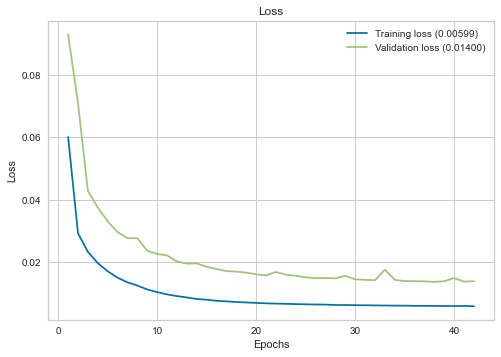

Test loss:                                                                                                             
0.04024232178926468                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05919, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05919 to 0.04778, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04778 to 0.04323, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

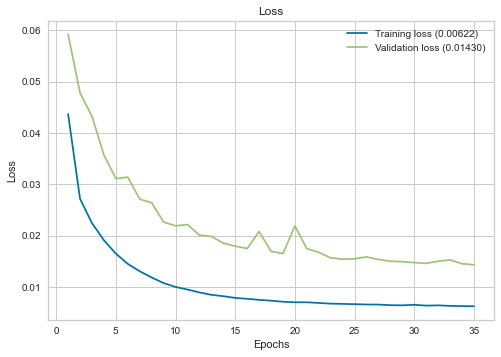

Test loss:                                                                                                             
0.027623610571026802                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07507, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07507 to 0.05578, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05578 to 0.04248, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

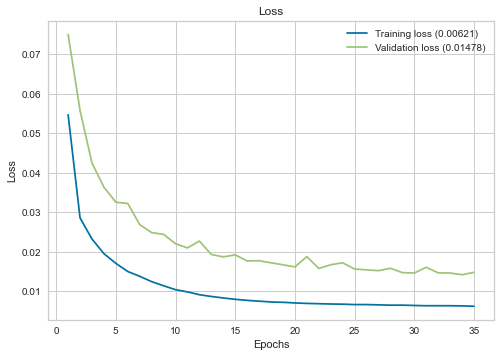

Test loss:                                                                                                             
0.014530607499182224                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06985, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06985 to 0.05676, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05676 to 0.04178, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

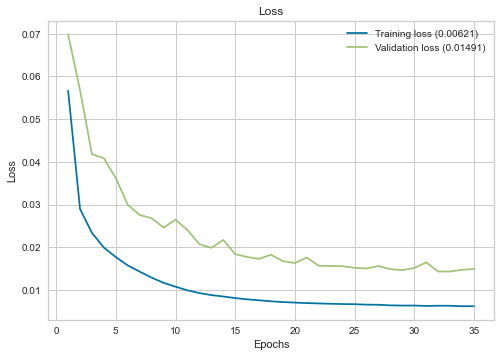

Test loss:                                                                                                             
0.018793560564517975                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05599, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05599 to 0.03950, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03950 to 0.03209, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

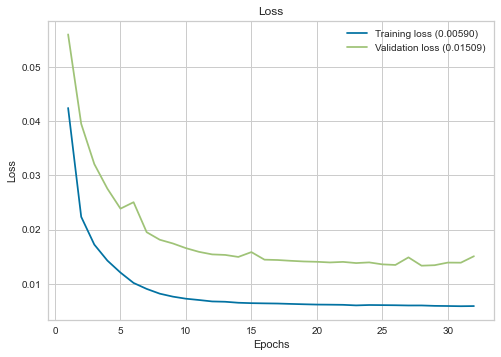

Test loss:                                                                                                             
0.06170874461531639                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07485, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07485 to 0.05320, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05320 to 0.04126, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

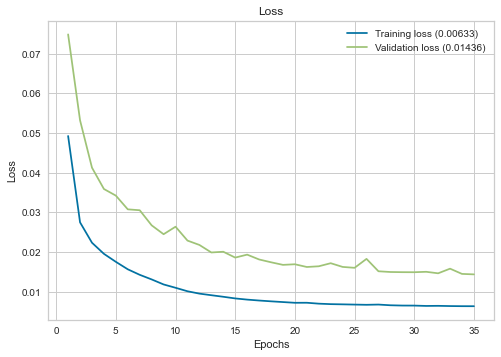

Test loss:                                                                                                             
0.02043410763144493                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06431, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06431 to 0.04898, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04898 to 0.04043, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

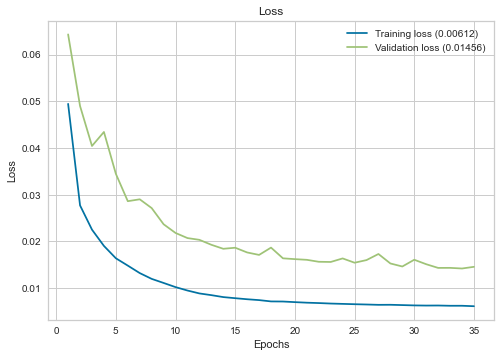

Test loss:                                                                                                             
0.013836177065968513                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.08325, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.08325 to 0.06430, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06430 to 0.04052, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

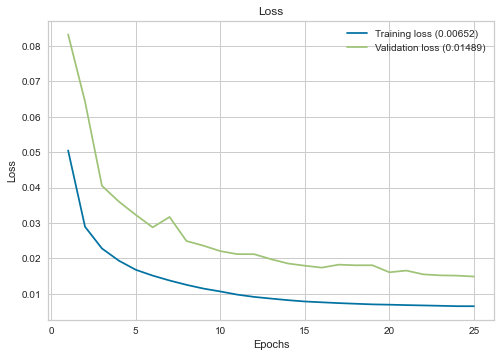

Test loss:                                                                                                             
0.0260771494358778                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.42177, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.42177 to 0.35165, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.35165 to 0.28738, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

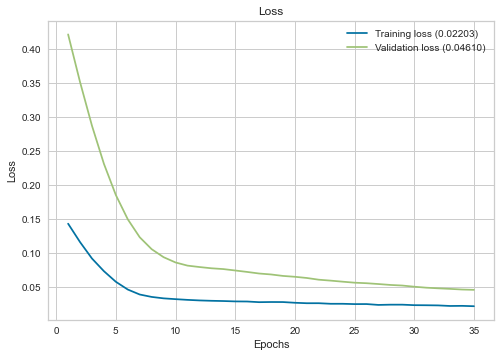

Test loss:                                                                                                             
0.1350942999124527                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07106, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07106 to 0.05849, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05849 to 0.04664, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

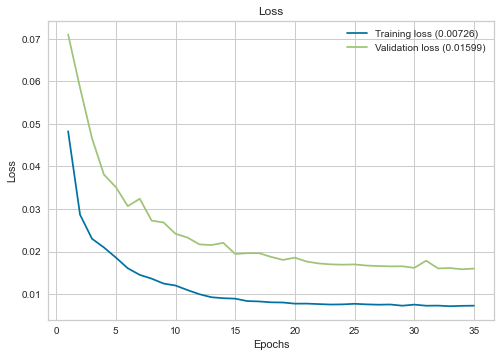

Test loss:                                                                                                             
0.03492027893662453                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.09269, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.09269 to 0.06832, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06832 to 0.05597, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

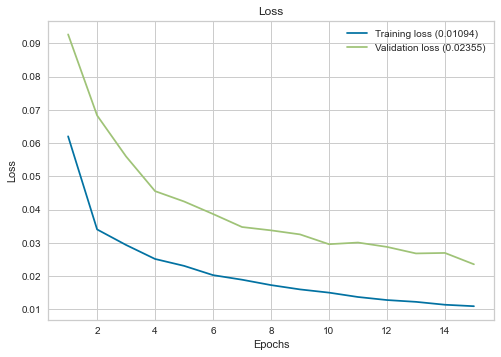

Test loss:                                                                                                             
0.05664221942424774                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07511, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07511 to 0.06427, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06427 to 0.04581, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

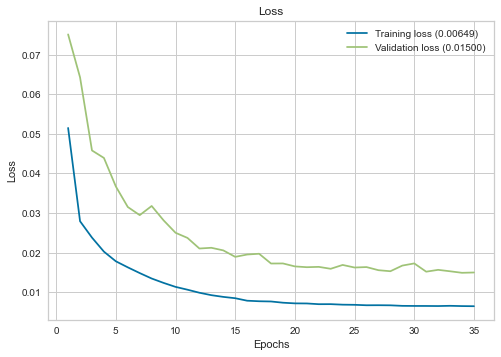

Test loss:                                                                                                             
0.04071364924311638                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.14139, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.14139 to 0.09103, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.09103 to 0.08266, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

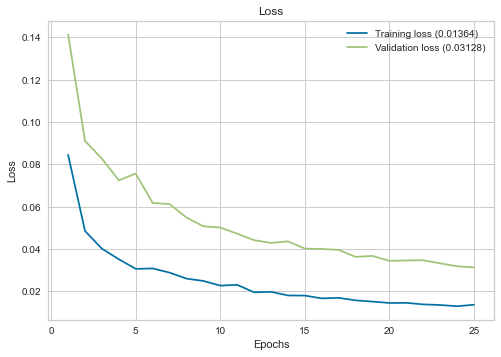

Test loss:                                                                                                             
0.11524908989667892                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.15287, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.15287 to 0.09389, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.09389 to 0.07430, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

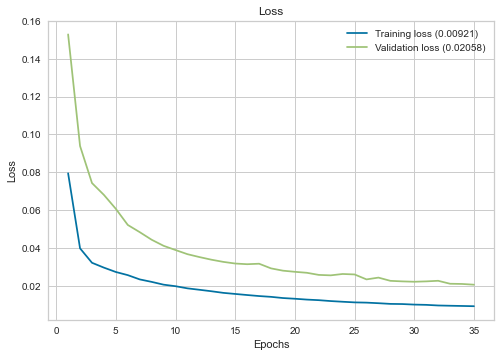

Test loss:                                                                                                             
0.020273171365261078                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05929, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05929 to 0.03851, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03851 to 0.03398, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

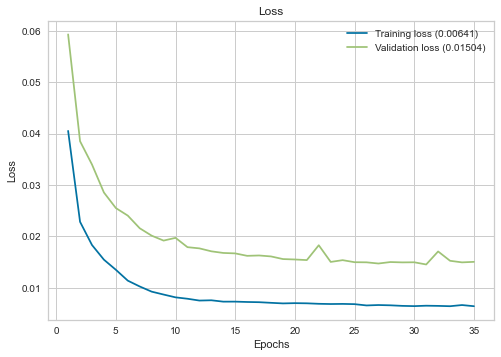

Test loss:                                                                                                             
0.05001896619796753                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07473, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07473 to 0.05356, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05356 to 0.03943, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00041: val_loss improved from 0.01391 to 0.01379, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.01379
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.01379
                                                                                                                       
Epoch 00044: val_loss did not improve from 0.01379
                                                                                                                       
Epoch 00045: val_loss did not improve from 0.01379
 70%|████████████████████████████████▏             | 35/50 [06:10<02:53, 11.58s/trial, best loss: 0.013836177065968513]

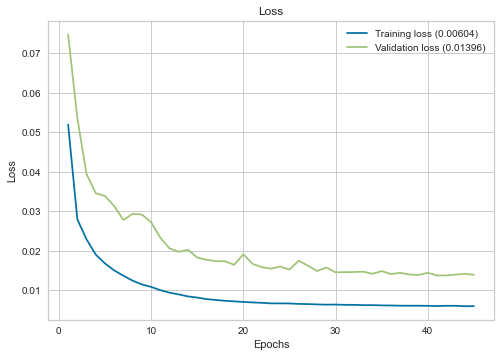

Test loss:                                                                                                             
0.01541666965931654                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.28207, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.28207 to 0.25143, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.25143 to 0.22573, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

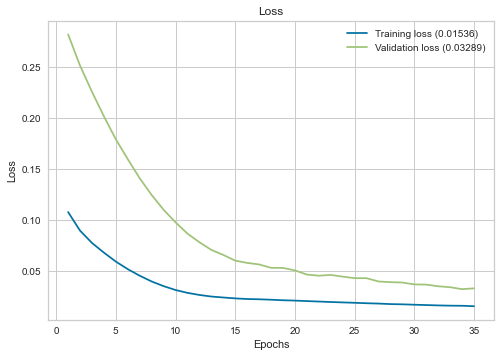

Test loss:                                                                                                             
0.11897079646587372                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07481, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07481 to 0.06626, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06626 to 0.05512, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

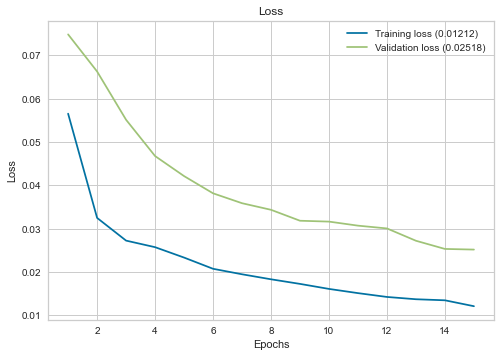

Test loss:                                                                                                             
0.06246970593929291                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.29798, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.29798 to 0.17814, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.17814 to 0.09353, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

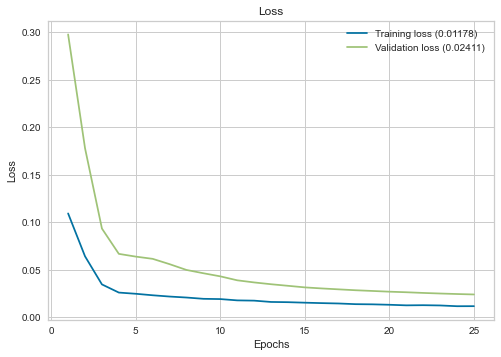

Test loss:                                                                                                             
0.05954744666814804                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05825, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05825 to 0.04026, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04026 to 0.03315, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

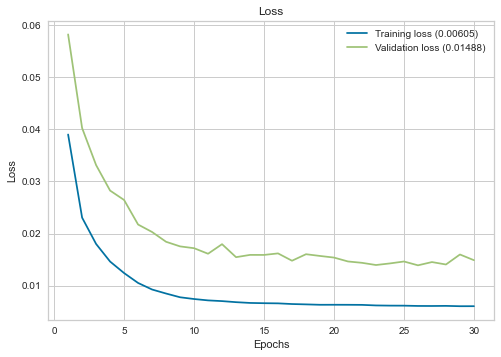

Test loss:                                                                                                             
0.054569561034440994                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.21359, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.21359 to 0.15157, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.15157 to 0.13096, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

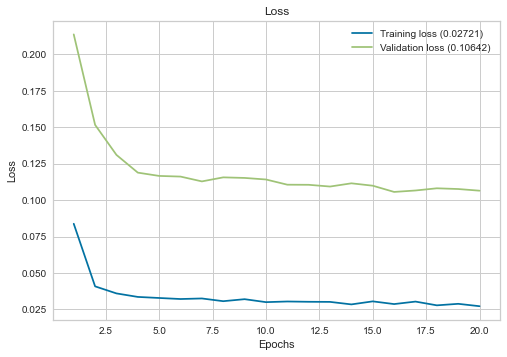

Test loss:                                                                                                             
0.30909013748168945                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05224, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05224 to 0.04097, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04097 to 0.02936, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

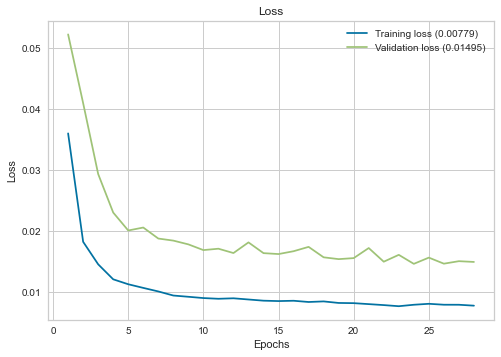

Test loss:                                                                                                             
0.040071338415145874                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.23801, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.23801 to 0.15022, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.15022 to 0.09800, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss improved from 0.02829 to 0.02797, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.02797 to 0.02763, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.02763 to 0.02721, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.02721 to 0.02688, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 

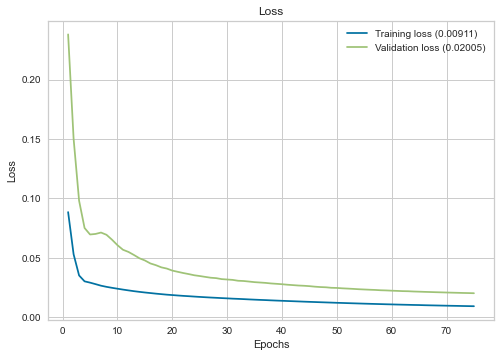

Test loss:                                                                                                             
0.02704295516014099                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.53133, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss did not improve from 0.53133
                                                                                                                       
Epoch 00003: val_loss improved from 0.53133 to 0.50633, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.50633


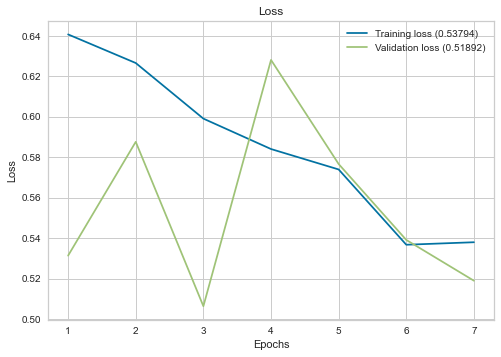

Test loss:                                                                                                             
0.2578137516975403                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.33537, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.33537 to 0.25827, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.25827 to 0.20357, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss improved from 0.08853 to 0.08755, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.08755 to 0.08470, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.08470 to 0.08444, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.08444 to 0.08254, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss did not improv

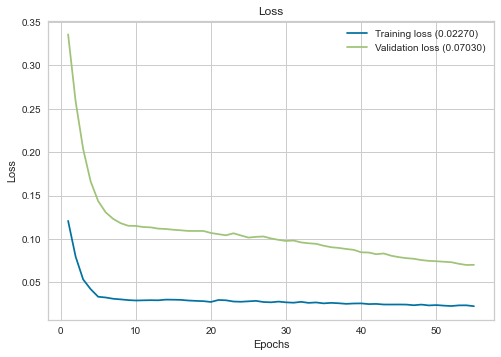

Test loss:                                                                                                             
0.23160751163959503                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.11646, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.11646 to 0.05935, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05935 to 0.05171, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

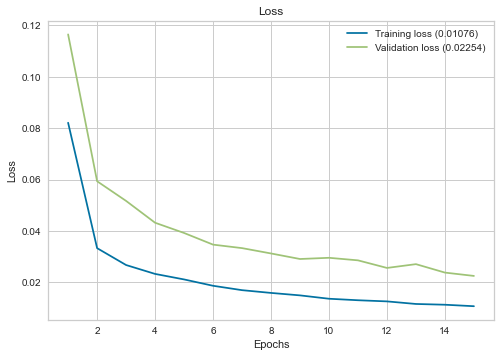

Test loss:                                                                                                             
0.0544607974588871                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.44509, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.44509 to 0.29546, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.29546
                                                                                                                       
Epoch 00004: val_loss improved from 0.29546 to 0.28

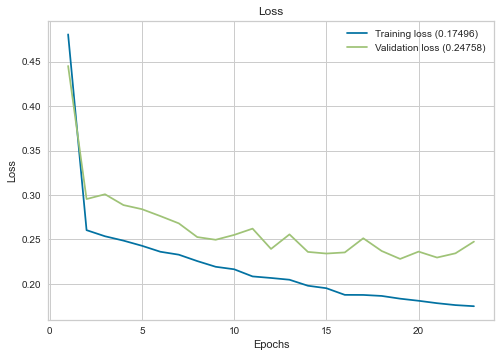

Test loss:                                                                                                             
0.31512415409088135                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.17385, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.17385 to 0.14237, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.14237 to 0.13461, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

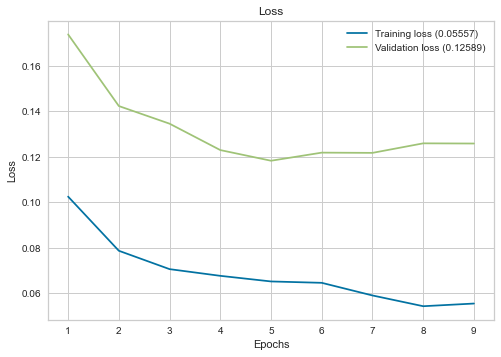

Test loss:                                                                                                             
0.33232468366622925                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.42981, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.42981 to 0.38146, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.38146 to 0.33675, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

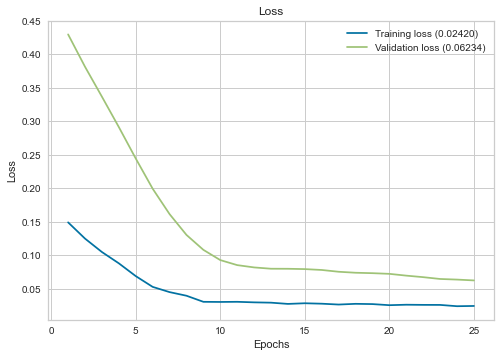

Test loss:                                                                                                             
0.21047182381153107                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.13176, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.13176 to 0.08060, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.08060 to 0.06858, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00040: val_loss did not improve from 0.01648
                                                                                                                       
Epoch 00041: val_loss improved from 0.01648 to 0.01640, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.01640 to 0.01621, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.01621 to 0.01591, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss did not improve from 0.01591
                                                                                                                       
Epoch 00045: val_loss did

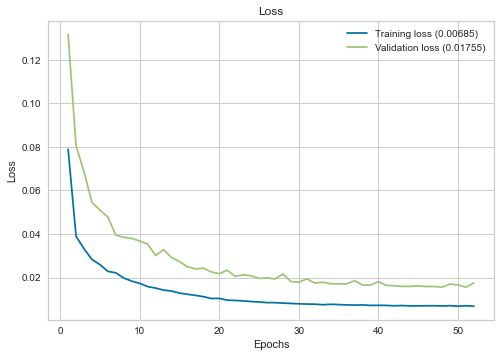

Test loss:                                                                                                             
0.06753033399581909                                                                                                    
100%|██████████████████████████████████████████████| 50/50 [08:33<00:00, 10.27s/trial, best loss: 0.013836177065968513]
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.3074621260166168, 'status': 'ok', 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001EA5CBE3730>}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'Activation': [0], 'LSTM': [0], 'batch_size': [0], 'epochs': [0], 'optimizer': [0], 'rate': [0]}, 'vals': {'Activation': [1], 'LSTM': [1], 'batch_size': [3], 'epochs': [6], 'optimizer': [0], 'rate': [0.4371162594318422]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 1, 29, 19, 36, 25, 917000), 'refresh_time': datetime.

In [1]:
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import keras.layers
import keras
import tensorflow as tf


from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas
import matplotlib.pyplot as plt
import pickle
import importlib

importlib.reload(np_utils)
importlib.reload(optim)


def plot_history(history):
    loss_list = [
        s for s in history.history.keys() if 'loss' in s and 'val' not in s
    ]
    val_loss_list = [
        s for s in history.history.keys() if 'loss' in s and 'val' in s
    ]
    acc_list = [
        s for s in history.history.keys() if 'acc' in s and 'val' not in s
    ]
    val_acc_list = [
        s for s in history.history.keys() if 'acc' in s and 'val' in s
    ]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs,
                 history.history[l],
                 'b',
                 label='Training loss (' +
                 str(str(format(history.history[l][-1], '.5f')) + ')'))
    for l in val_loss_list:
        plt.plot(epochs,
                 history.history[l],
                 'g',
                 label='Validation loss (' +
                 str(str(format(history.history[l][-1], '.5f')) + ')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def data():
    global scaler

    import pandas as pd
    import pandas

    dataset = read_csv('data/train.csv', index_col="Date")
    values = dataset.values

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled = scaler.fit_transform(values)
    scaled = pd.DataFrame(scaled)

    def ts(dataset, look_back=9, pred_col=1):
        t = dataset.copy()
        t['id'] = range(1, len(t) + 1)
        t = t.iloc[:-look_back, :]
        t.set_index('id', inplace=True)
        pred_value = dataset.copy()
        pred_value = pred_value.iloc[look_back:, pred_col]
        pred_value.columns = ['close_nextday']
        pred_value = pd.DataFrame(pred_value)

        pred_value['id'] = range(1, len(pred_value) + 1)
        pred_value.set_index('id', inplace=True)
        df = pd.concat([t, pred_value], axis=1)

        return df

    arr_df = ts(scaled, 9, 0)
    arr_df.fillna(0, inplace=True)
    arr_df.columns = [
        'var_1(t-9)', 'var_2(t-9)', 'var_3(t-9)', 'var_4(t-9)', 'var_5(t-9)',
        'var_6(t-9)', 'var_7(t-9)', 'var_8(t-9)', 'var_1(t)'
    ]

    arr_df = arr_df.drop(['var_8(t-9)'], axis=1)

    values = arr_df.values
    train_sample = int(len(dataset) * 0.8)
    train = values[:train_sample, :]
    test = values[train_sample:, :]

    X_train = train[:352]
    y_train = train[:352]
    X_test = test[:80]
    y_test = test[:80]

    y_train = np.delete(y_train, range(0, 7), 1)
    y_train = y_train.ravel()

    y_test = np.delete(y_test, range(0, 7), 1)
    y_test = y_test.ravel()

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, y_train, X_test, y_test


def model(X_train, y_train, X_test, y_test):

    import tensorflow as tf
    from keras.layers import Bidirectional
    from tensorflow.keras import regularizers

    acc_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    acc_metric2 = tf.keras.metrics.MeanSquaredLogarithmicError()
    acc_metric3 = tf.keras.metrics.MeanAbsoluteError()
    acc_metric4 = tf.keras.metrics.MeanSquaredError()
    acc_metric5 = tf.keras.metrics.RootMeanSquaredError()
    
    model = Sequential()
    model.add(
        LSTM({{choice([10, 20, 30, 40, 50, 60, 70, 80])}},
             input_shape=(X_train.shape[1], X_train.shape[2]),
             return_sequences=True))
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'linear', 'softmax',
                             'elu'])}}, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(rate={{uniform(0, 1)}}))
    model.add(Dense(1, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.compile(
        loss='mse',
        optimizer={{choice(['adamax', 'rmsprop', 'adam', 'sgd', 'nadam'])}},
        metrics=[acc_metric5])

    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

    history = model.fit(X_train,
                        y_train,
                        epochs={{choice([15, 25, 35, 45, 55, 65, 75])}},
                        verbose=0,
                        batch_size={{choice([2, 4, 5, 8, 10, 16, 20, 40,
                                             80])}},
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer])

    plot_history(history)

    f = open('history.pckl', 'wb')
    pickle.dump(history.history, f)
    f.close()

    score = model.evaluate(X_test, y_test, verbose=0)
    rmse = score[1]
    print('Test loss:', rmse)
    return {'loss': rmse, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':

    X_train, y_train, X_test, y_test = data()
    functions = [plot_history]
    trials = Trials()
    best_run, best_model = optim.minimize(
        model=model,
        data=data,
        functions=functions,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        notebook_name='BTC_Prediction (Modeling Stage)')

    for trial in trials.trials[:5]:
        print(trial)

    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_test, y_test))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

In [2]:
f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [3]:
print(history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


In [4]:
%matplotlib inline

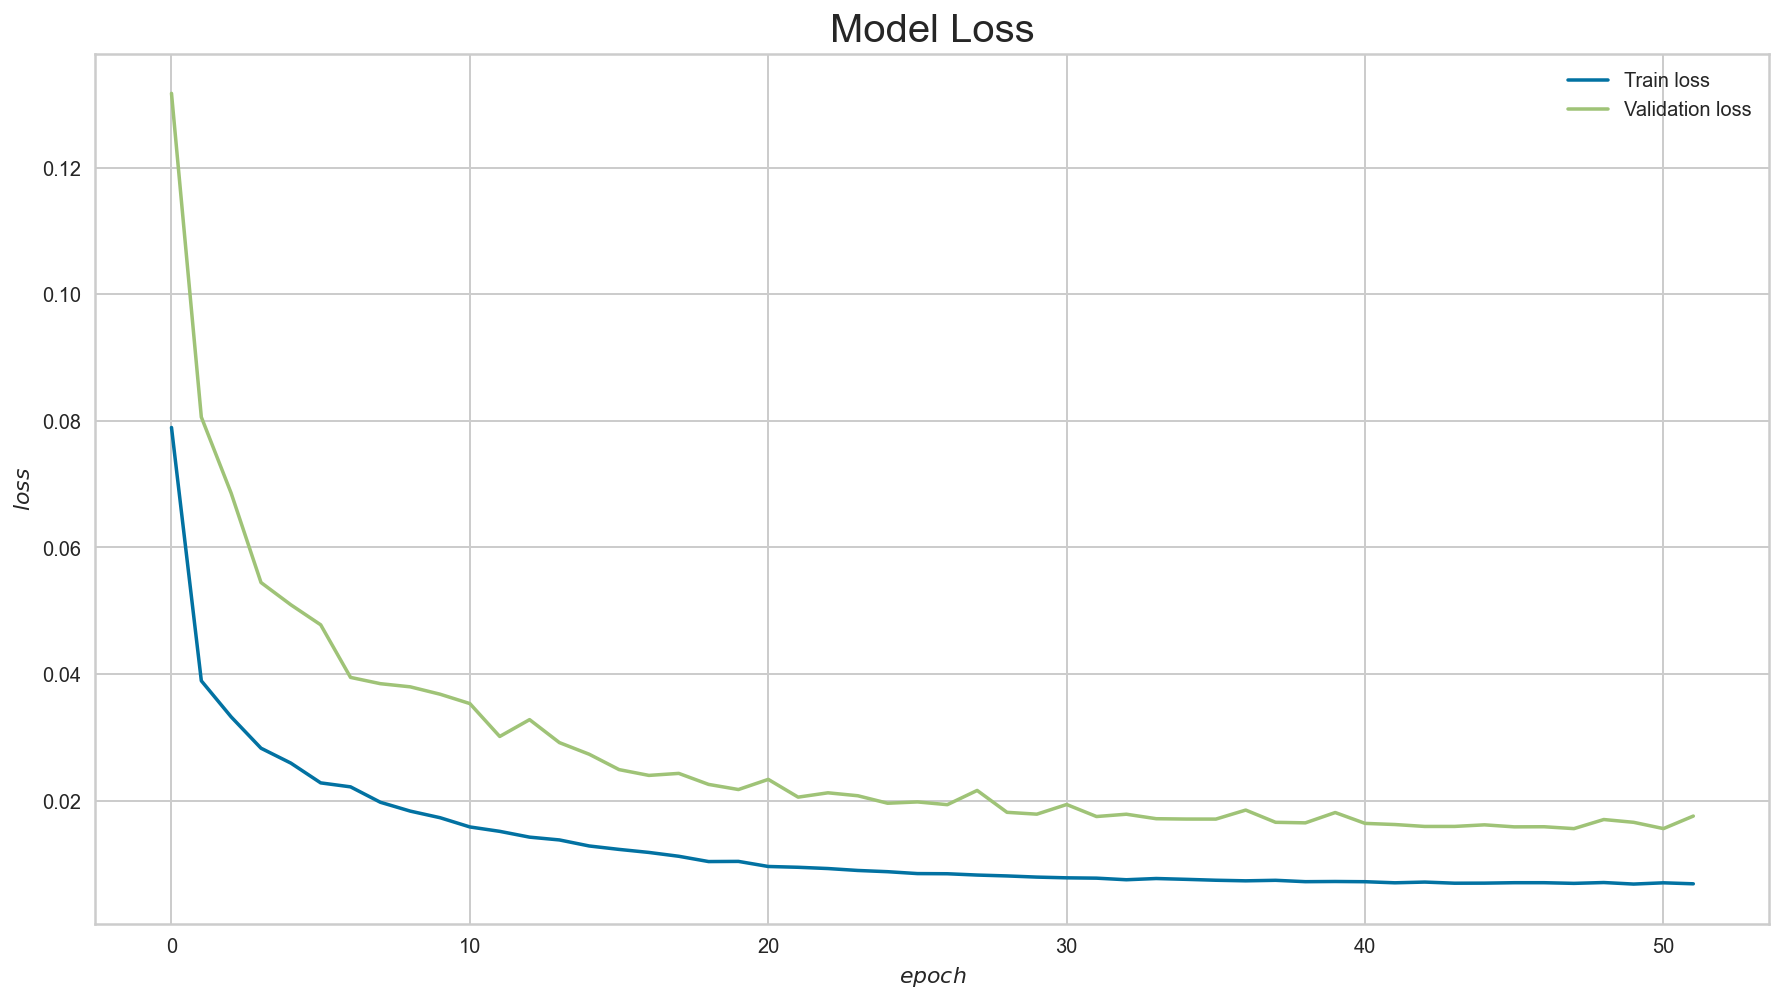

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

plt.figure(figsize=(15,8))
plt.plot(history['loss'], 'b')
plt.plot(history['val_loss'], 'g')
plt.title('Model Loss', fontsize=20)
plt.ylabel('$loss$')
plt.xlabel('$epoch$')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plt.savefig('LSTM_evaluation_lossplot.png', transparent=False)

plt.show()

In [6]:
y_pred = best_model.predict(X_test)

In [7]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [8]:
y_pred = y_pred.reshape(-1,1)

inv_ypred = np.concatenate((y_pred, X_test[:,1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

In [9]:
print(X_test.shape, y_pred.shape)

(80, 8) (80, 1)


In [10]:
y_test = y_test.reshape((len(y_test), 1))

inv_ytest = np.concatenate((y_test, X_test[:,1:]), axis=1)
inv_ytest = scaler.inverse_transform(inv_ytest)
inv_ytest = inv_ytest[:,0]

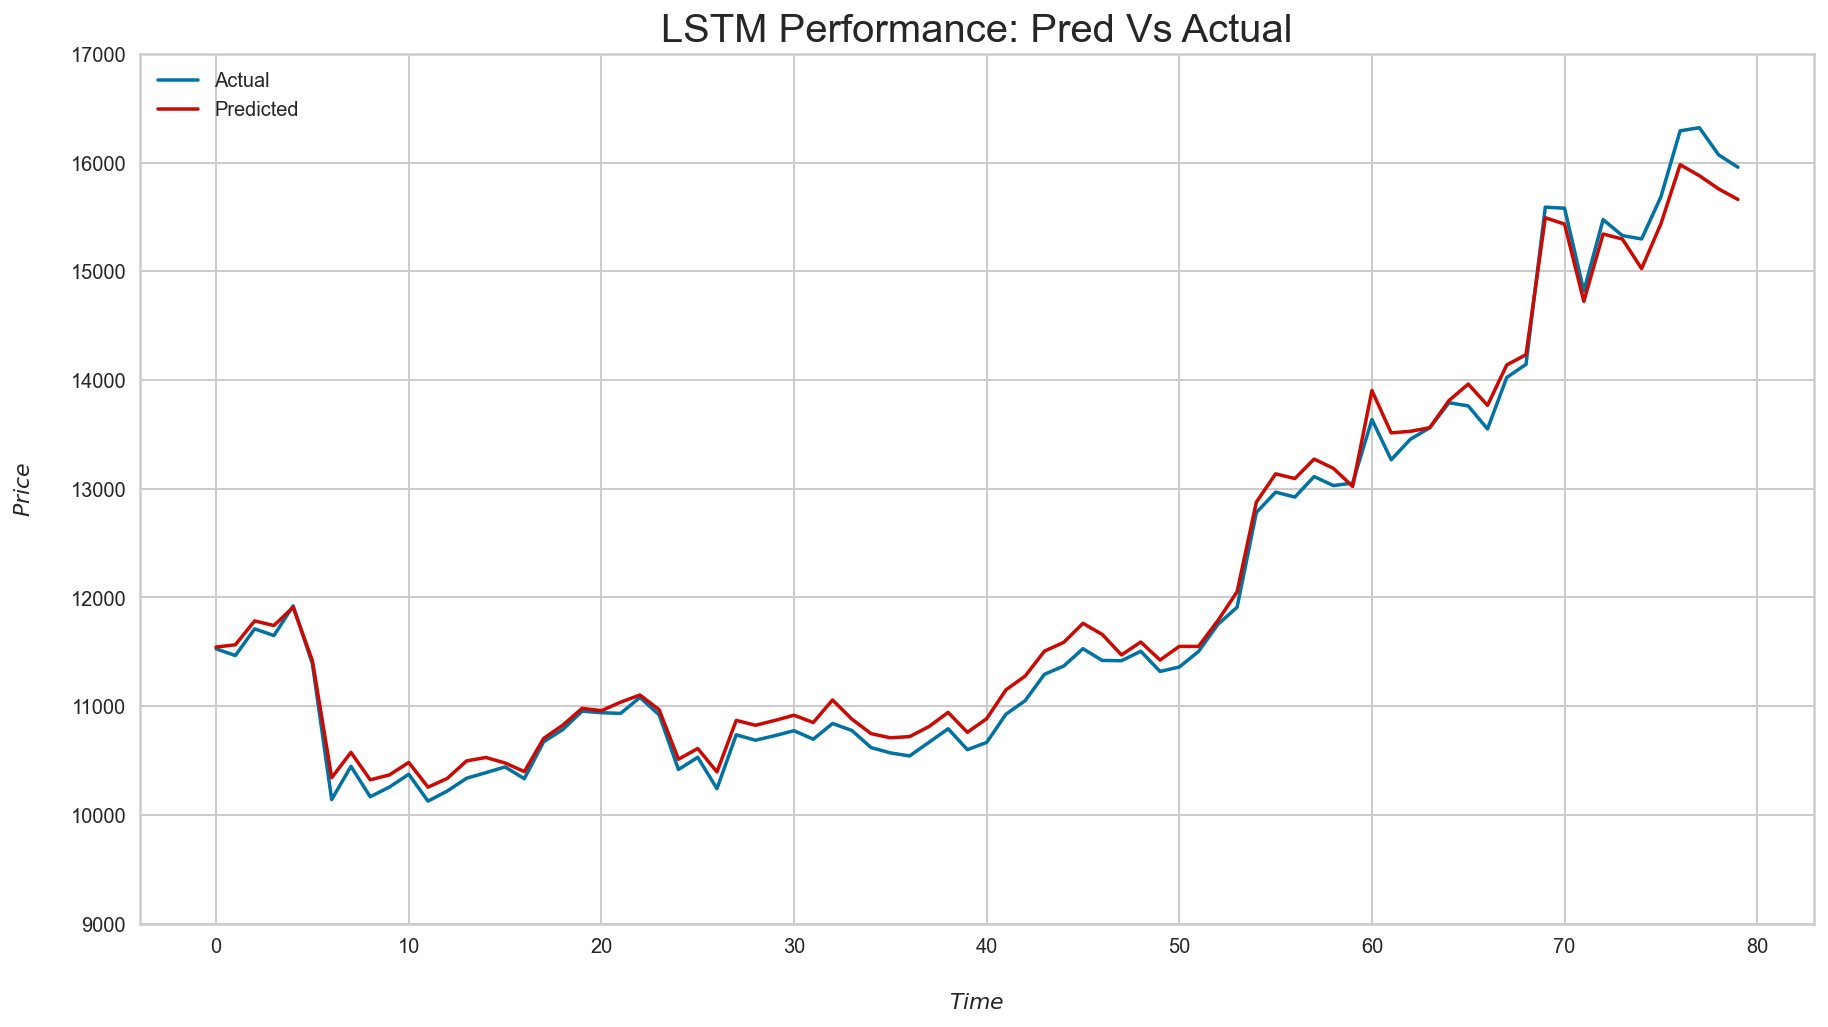

In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.figure(figsize=(15,8))
plt.plot(inv_ytest, 'b', label='Actual')
plt.plot(inv_ypred, 'r', label='Predicted')

plt.title('LSTM Performance: Pred Vs Actual', fontsize=20)
plt.ylabel('$Price$', labelpad=18, )
plt.yticks(np.arange(9000, 18000, 1000))
plt.xlabel('$Time$', labelpad=18)
plt.legend()

plt.savefig('LSTM_ActualVsPred_plot.png', transparent=False)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate2(inv_ypred, inv_ytest, label='Test Scores:\n'):
    mse = mean_squared_error(inv_ytest, inv_ypred)
    rmse = np.sqrt(mse)
    variance = r2_score(inv_ytest, inv_ypred)
    print('{}  \nRMSE:{} \nR2:{}'.format(label, rmse, variance))

In [13]:
evaluate2(inv_ypred, inv_ytest)

Test Scores:
  
RMSE:159.40241255595492 
R2:0.992226931084707
